# Text-to-Image Generation and Infinite zoom with Stable Diffusion v2 and OpenVINO™

Stable Diffusion V2 is the next generation of Stable Diffusion model a text-to-image latent diffusion model created by the researchers and engineers from [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). 

General diffusion models are machine learning systems that are trained to denoise random gaussian noise step by step, to get to a sample of interest, such as an image.
Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference. OpenVINO brings capabilities to run model inference on Intel hardware and opens the door to the fantastic world of diffusion models for everyone!

In previous notebooks, we already discussed how to run Text-to-Image generation and Image-to-Image generation using Stable Diffusion v1 and controlling its generation process using ControlNet. Now is turn of Stable Diffusion V2.

## Stable Diffusion V2: What’s new?

The new stable diffusion model offers a bunch of new features inspired by the other models that have emerged since the introduction of the first iteration. Some of the features that can be found in the new model are:
* The model comes with a new robust encoder, OpenClip, created by LAION and aided by Stability AI; this version V2 significantly enhances the produced photos over the V1 versions. 
* The model can now generate images in a 768x768 resolution, offering more information to be shown in the generated images.
* The model finetuned with [v-objective](https://arxiv.org/abs/2202.00512). The v-parameterization is particularly useful for numerical stability throughout the diffusion process to enable progressive distillation for models. For models that operate at higher resolution, it is also discovered that the v-parameterization avoids color shifting artifacts that are known to affect high resolution diffusion models, and in the video setting it avoids temporal color shifting that sometimes appears with epsilon-prediction used in Stable Diffusion v1. 
* The model also comes with a new diffusion model capable of running upscaling on the images generated. Upscaled images can be adjusted up to 4 times the original image. Provided as separated model, for more details please check [stable-diffusion-x4-upscaler](https://huggingface.co/stabilityai/stable-diffusion-x4-upscaler)
* The model comes with a new refined depth architecture capable of preserving context from prior generation layers in an img2img setting. This structure preservation helps generate images that preserving forms and shadow of objects, but with different content.
* The model comes with an updated inpainting module built upon the previous model. This text-guided inpainting makes switching out parts in the image easier than before.

This notebook demonstrates how to convert and run Stable Diffusion v2 model using OpenVINO.

Notebook contains the following steps:
1. Convert PyTorch models to ONNX format.
2. Convert ONNX models to OpenVINO IR format, using Model Optimizer tool.
3. Run Stable Diffusion V2 text-to-image pipeline with OpenVINO.
4. Run Stable Diffusion V2 inpainting pipeline for generation infinity zoom out video

## Prerequisites
install required packages

In [1]:
!pip install -q "diffusers>=0.14.0" 


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


## Stable Diffusion V2 for Text-to-Image Generation

To start, let's look on Text to Image process for Stable Diffusion V2. We will use [stabilitai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1) model for these purposes. The main difference from Stable Diffusion v2 and Stable Diffusion V2.1 is usage of more data, more training, and less restrictive filtering of the dataset, that gives promising results for selecting wide range of input text prompts. More details about model can be found in [Stability AI blog post](https://stability.ai/blog/stablediffusion2-1-release7-dec-2022) and original model [repository](https://github.com/Stability-AI/stablediffusion).

### Stable Diffusion in Diffusers library
To work with Stable Diffusion v2, we will use Hugging Face [Diffusers](https://github.com/huggingface/diffusers) library. To experiment with Stable Diffusion models, Diffusers exposes the [StableDiffusionPipeline](https://huggingface.co/docs/diffusers/using-diffusers/conditional_image_generation) similar to the [other Diffusers pipelines](https://huggingface.co/docs/diffusers/api/pipelines/overview).  The code below demonstrates how to create `StableDiffusionPipeline` using `stable-diffusion-2-1`:

In [2]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1").to("cpu")

# for reducing memory consumption get all components from pipeline independently
text_encoder = pipe.text_encoder
text_encoder.eval()
unet = pipe.unet
unet.eval()
vae = pipe.vae
vae.eval()

conf = pipe.scheduler.config

del pipe

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/home/ea/work/transformers/src/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


### Convert models to OpenVINO Intermediate representation (IR) format

OpenVINO supports PyTorch through export to the ONNX format. We will use the `torch.onnx.export` function to obtain the ONNX model, 
we can learn more in the [PyTorch documentation](https://pytorch.org/docs/stable/onnx.html). We need to provide a model object, input data for model tracing, and a path for saving the model. Optionally, we can provide a target ONNX opset for conversion and other parameters specified in the documentation (for example, input and output names or dynamic shapes).

While ONNX models are directly supported by OpenVINO™ runtime, it can be useful to convert them to IR format to take the advantage of advanced OpenVINO optimization tools and features. We will use OpenVINO [Model Optimizer](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) to convert a model to IR format and compression weights to `FP16` format.


The pipeline consists of three important parts:
* Text Encoder to create condition to generate an image from a text prompt.
* Unet for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

Let us convert each part:

### Text Encoder

The text-encoder is responsible for transforming the input prompt, for example, "a photo of an astronaut riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

The input of the text encoder is tensor `input_ids`, which contains indexes of tokens from text processed by the tokenizer and padded to the maximum length accepted by the model. Model outputs are two tensors: `last_hidden_state` - hidden state from the last MultiHeadAttention layer in the model and `pooler_out` - pooled output for whole model hidden states. We will use `opset_version=14` because the model contains the `triu` operation, supported in ONNX only starting from this opset.

In [3]:
from pathlib import Path

sd2_1_model_dir = Path("sd2.1")
sd2_1_model_dir.mkdir(exist_ok=True)

In [4]:
import gc
import torch

TEXT_ENCODER_ONNX_PATH = sd2_1_model_dir / 'text_encoder.onnx'
TEXT_ENCODER_OV_PATH = TEXT_ENCODER_ONNX_PATH.with_suffix('.xml')


def convert_encoder_onnx(text_encoder: torch.nn.Module, onnx_path:Path):
    """
    Convert Text Encoder model to ONNX. 
    Function accepts pipeline, prepares example inputs for ONNX conversion via torch.export, 
    Parameters: 
        text_encoder (torch.nn.Module): text encoder PyTorch model
        onnx_path (Path): File for storing onnx model
    Returns:
        None
    """
    if not onnx_path.exists():
        input_ids = torch.ones((1, 77), dtype=torch.long)
        # switch model to inference mode
        text_encoder.eval()

        # disable gradients calculation for reducing memory consumption
        with torch.no_grad():
            # export model to ONNX format
            torch.onnx.export(
                text_encoder,  # model instance
                input_ids,  # inputs for model tracing
                onnx_path,  # output file for saving result
                input_names=['tokens'],  # model input name for onnx representation
                output_names=['last_hidden_state', 'pooler_out'],  # model output names for onnx representation
                opset_version=14  # onnx opset version for export
            )
        print('Text Encoder successfully converted to ONNX')
    

if not TEXT_ENCODER_OV_PATH.exists():
    convert_encoder_onnx(text_encoder, TEXT_ENCODER_ONNX_PATH)
    !mo --input_model $TEXT_ENCODER_ONNX_PATH --compress_to_fp16 --output_dir $sd2_1_model_dir
    print('Text Encoder successfully converted to IR')
else:
    print(f"Text encoder will be loaded from {TEXT_ENCODER_OV_PATH}")

del text_encoder
gc.collect()

Text encoder will be loaded from sd2.1/text_encoder.xml


0

### Unet

Unet model gradually denoises latent image representation guided by text encoder hidden state.

Unet model has three inputs:
* `sample` - latent image sample from previous step. Generation process has not been started yet, so you will use random noise.
* `timestep` - current scheduler step.
* `encoder_hidden_state` - hidden state of text encoder.

Model predicts the `sample` state for the next step.

Generally, Unet model conversion process remain the same like in Stable Diffusion v1, expect small changes in input sample size.  Our model was pretrained to generate images with resolution 768x768, initial latent sample size for this case is 96x96. Besides that, for different use cases like inpainting and depth to image generation model also can accept additional image information: depth map or mask as channel-wise concatenation with initial latent sample. For convering UNet model for such use cases required to modify number of input channels.

In [5]:
import numpy as np

UNET_ONNX_PATH = sd2_1_model_dir / 'unet/unet.onnx'
UNET_OV_PATH = UNET_ONNX_PATH.parents[1] / 'unet.xml'


def convert_unet_onnx(unet:torch.nn.Module, onnx_path:Path, num_channels:int = 4, width:int = 64, height:int = 64):
    """
    Convert Unet model to ONNX, then IR format. 
    Function accepts pipeline, prepares example inputs for ONNX conversion via torch.export, 
    Parameters: 
        unet (torch.nn.Module): UNet PyTorch model
        onnx_path (Path): File for storing onnx model
        num_channels (int, optional, 4): number of input channels
        width (int, optional, 64): input width
        height (int, optional, 64): input height
    Returns:
        None
    """
    if not onnx_path.exists():
        # prepare inputs
        encoder_hidden_state = torch.ones((2, 77, 1024))
        latents_shape = (2, num_channels, width, height)
        latents = torch.randn(latents_shape)
        t = torch.from_numpy(np.array(1, dtype=float))

        # model size > 2Gb, it will be represented as onnx with external data files, we will store it in separated directory for avoid a lot of files in current directory
        onnx_path.parent.mkdir(exist_ok=True, parents=True)
        unet.eval()

        with torch.no_grad():
            torch.onnx.export(
                unet, 
                (latents, t, encoder_hidden_state), str(onnx_path),
                input_names=['latent_model_input', 't', 'encoder_hidden_states'],
                output_names=['out_sample']
                
            )
        print('Unet successfully converted to ONNX')


if not UNET_OV_PATH.exists():
    convert_unet_onnx(unet, UNET_ONNX_PATH, width=96, height=96)
    del unet
    gc.collect()
    !mo --input_model $UNET_ONNX_PATH --compress_to_fp16 --output_dir $sd2_1_model_dir
    print('Unet successfully converted to IR')
else:
    del unet
    print(f"Unet will be loaded from {UNET_OV_PATH}")
gc.collect()

Unet will be loaded from sd2.1/unet.xml


0

### VAE

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.

During latent diffusion training, the encoder is used to get the latent representations (latents) of the images for the forward diffusion process, which applies more and more noise at each step. During inference, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. When you run inference for text-to-image, there is no initial image as a starting point. You can skip this step and directly generate initial random noise.

During running text-to-image pipeline, we will see that we **only need the VAE decoder**, but preserve VAE encoder conversion, it will be useful in next chapter of our tutorial. 

In [6]:
VAE_ENCODER_ONNX_PATH = sd2_1_model_dir / 'vae_encoder.onnx'
VAE_ENCODER_OV_PATH = VAE_ENCODER_ONNX_PATH.with_suffix('.xml')


def convert_vae_encoder_onnx(vae: torch.nn.Module, onnx_path: Path, width:int=512, height:int=512):
    """
    Convert VAE model to ONNX, then IR format. 
    Function accepts pipeline, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for ONNX conversion via torch.export, 
    Parameters: 
        vae (torch.nn.Module): VAE PyTorch model
        onnx_path (Path): File for storing onnx model
        width (int, optional, 512): input width
        height (int, optional, 512): input height
    Returns:
        None
    """
    class VAEEncoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, image):
            h = self.vae.encoder(image)
            moments = self.vae.quant_conv(h)
            return moments

    if not onnx_path.exists():
        vae_encoder = VAEEncoderWrapper(vae)
        vae_encoder.eval()
        image = torch.zeros((1, 3, width, height))
        with torch.no_grad():
            torch.onnx.export(vae_encoder, image, onnx_path, input_names=[
                              'init_image'], output_names=['image_latent'])
        print('VAE encoder successfully converted to ONNX')


if not VAE_ENCODER_OV_PATH.exists():
    convert_vae_encoder_onnx(vae, VAE_ENCODER_ONNX_PATH, 768, 768)
    !mo --input_model $VAE_ENCODER_ONNX_PATH --compress_to_fp16 --output_dir $sd2_1_model_dir
    print('VAE encoder successfully converted to IR')
else:
    print(f"VAE encoder will be loaded from {VAE_ENCODER_OV_PATH}")

VAE_DECODER_ONNX_PATH = sd2_1_model_dir / 'vae_decoder.onnx'
VAE_DECODER_OV_PATH = VAE_DECODER_ONNX_PATH.with_suffix('.xml')


def convert_vae_decoder_onnx(vae: torch.nn.Module, onnx_path: Path, width:int = 64, height:int = 64):
    """
    Convert VAE model to ONNX, then IR format. 
    Function accepts pipeline, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for ONNX conversion via torch.export, 
    Parameters: 
        vae: 
        onnx_path (Path): File for storing onnx model
        width (int, optional, 64): input width
        height (int, optional, 64): input height
    Returns:
        None
    """
    class VAEDecoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, latents):
            latents = 1 / 0.18215 * latents 
            return self.vae.decode(latents)

    if not onnx_path.exists():
        vae_decoder = VAEDecoderWrapper(vae)
        latents = torch.zeros((1, 4, width, height))

        vae_decoder.eval()
        with torch.no_grad():
            torch.onnx.export(vae_decoder, latents, onnx_path, input_names=[
                              'latents'], output_names=['sample'])
        print('VAE decoder successfully converted to ONNX')


if not VAE_DECODER_OV_PATH.exists():
    convert_vae_decoder_onnx(vae, VAE_DECODER_ONNX_PATH, 96, 96)
    !mo --input_model $VAE_DECODER_ONNX_PATH --compress_to_fp16 --output_dir $sd2_1_model_dir
    print('VAE decoder successfully converted to IR')
else:
    print(f"VAE decoder will be loaded from {VAE_DECODER_OV_PATH}")

del vae

VAE encoder will be loaded from sd2.1/vae_encoder.xml
VAE decoder will be loaded from sd2.1/vae_decoder.xml


# Prepare Inference Pipeline

Putting it all together, let us now take a closer look at how the model works in inference by illustrating the logical flow.

![text2image stable diffusion v2](https://user-images.githubusercontent.com/29454499/228472288-be6fecb6-5ab5-411f-86dc-0e9c482c733e.png)
The stable diffusion model takes both a latent seed and a text prompt as input. The latent seed is then used to generate random latent image representations of size $96 \times 96$ where as the text prompt is transformed to text embeddings of size $77 \times 1024$ via OpenCLIP's text encoder.

Next, the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, it is recommended to use one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py)
- [DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)

Theory on how the scheduler algorithm function works is out of scope for this notebook, but in short, you should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, it is recommended to look into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364).


The chart above looks very similar to Stable Diffusion V1 from notebook, but there is some small difference in details:
* Changed input resolution for UNet model
* Changed size of text encoder produced embeddings
* Additionally, to improve image generation quality authors introduced negative prompting. Technically, positive prompt steers the diffusion toward the images associated with it, while negative prompt steers the diffusion away from it.In other words, negative prompt declares undesired concepts for generation image, e.g. if we want to have colorful and bright image, gray scale image will be result which we want to avoid, in this case grey scale can be treated as negative prompt. The positive and negative prompt are in equal footing. You can always use one with or without the other. More explanation of how it works can be found in this [article](https://stable-diffusion-art.com/how-negative-prompt-work/). 

In [7]:
import inspect
from typing import List, Optional, Union, Dict

import PIL
import cv2
import torch
import numpy as np

from transformers import CLIPTokenizer
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
from openvino.runtime import Model


def scale_fit_to_window(dst_width:int, dst_height:int, image_width:int, image_height:int):
    """
    Preprocessing helper function for calculating image size for resize with peserving original aspect ratio 
    and fitting image to specific window size
    
    Parameters:
      dst_width (int): destination window width
      dst_height (int): destination window height
      image_width (int): source image width
      image_height (int): source image height
    Returns:
      result_width (int): calculated width for resize
      result_height (int): calculated height for resize
    """
    im_scale = min(dst_height / image_height, dst_width / image_width)
    return int(im_scale * image_width), int(im_scale * image_height)


def preprocess(image: PIL.Image.Image):
    """
    Image preprocessing function. Takes image in PIL.Image format, resizes it to keep aspect ration and fits to model input window 512x512,
    then converts it to np.ndarray and adds padding with zeros on right or bottom side of image (depends from aspect ratio), after that
    converts data to float32 data type and change range of values from [0, 255] to [-1, 1], finally, converts data layout from planar NHWC to NCHW.
    The function returns preprocessed input tensor and padding size, which can be used in postprocessing.
    
    Parameters:
      image (PIL.Image.Image): input image
    Returns:
       image (np.ndarray): preprocessed image tensor
       meta (Dict): dictionary with preprocessing metadata info
    """
    src_width, src_height = image.size
    dst_width, dst_height = scale_fit_to_window(
        512, 512, src_width, src_height)
    image = np.array(image.resize((dst_width, dst_height),
                     resample=PIL.Image.Resampling.LANCZOS))[None, :]
    pad_width = 512 - dst_width
    pad_height = 512 - dst_height
    pad = ((0, 0), (0, pad_height), (0, pad_width), (0, 0))
    image = np.pad(image, pad, mode="constant")
    image = image.astype(np.float32) / 255.0
    image = 2.0 * image - 1.0
    image = image.transpose(0, 3, 1, 2)
    return image, {"padding": pad, "src_width": src_width, "src_height": src_height}


class OVStableDiffusionPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae_decoder: Model,
        text_encoder: Model,
        tokenizer: CLIPTokenizer,
        unet: Model,
        scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
        vae_encoder: Model = None,
    ):
        """
        Pipeline for text-to-image generation using Stable Diffusion.
        Parameters:
            vae (Model):
                Variational Auto-Encoder (VAE) Model to decode images to and from latent representations.
            text_encoder (Model):
                Frozen text-encoder. Stable Diffusion uses the text portion of
                [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
                the clip-vit-large-patch14(https://huggingface.co/openai/clip-vit-large-patch14) variant.
            tokenizer (CLIPTokenizer):
                Tokenizer of class CLIPTokenizer(https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
            unet (Model): Conditional U-Net architecture to denoise the encoded image latents.
            scheduler (SchedulerMixin):
                A scheduler to be used in combination with unet to denoise the encoded image latents. Can be one of
                DDIMScheduler, LMSDiscreteScheduler, or PNDMScheduler.
        """
        super().__init__()
        self.scheduler = scheduler
        self.vae_decoder = vae_decoder
        self.vae_encoder = vae_encoder
        self.text_encoder = text_encoder
        self.unet = unet
        self._text_encoder_output = text_encoder.output(0)
        self._unet_output = unet.output(0)
        self._vae_d_output = vae_decoder.output(0)
        self._vae_e_output = vae_encoder.output(0) if vae_encoder is not None else None
        self.height = self.unet.input(0).shape[2] * 8
        self.width = self.unet.input(0).shape[3] * 8
        self.tokenizer = tokenizer

    def __call__(
        self,
        prompt: Union[str, List[str]],
        image: PIL.Image.Image = None,
        negative_prompt: Union[str, List[str]] = None,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0.0,
        output_type: Optional[str] = "pil",
        seed: Optional[int] = None,
        strength: float = 1.0,
    ):
        """
        Function invoked when calling the pipeline for generation.
        Parameters:
            prompt (str or List[str]):
                The prompt or prompts to guide the image generation.
            image (PIL.Image.Image, *optional*, None):
                 Intinal image for generation.
            num_inference_steps (int, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (float, *optional*, defaults to 7.5):
                Guidance scale as defined in Classifier-Free Diffusion Guidance(https://arxiv.org/abs/2207.12598).
                guidance_scale is defined as `w` of equation 2.
                Higher guidance scale encourages to generate images that are closely linked to the text prompt,
                usually at the expense of lower image quality.
            eta (float, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [DDIMScheduler], will be ignored for others.
            output_type (`str`, *optional*, defaults to "pil"):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): PIL.Image.Image or np.array.
            seed (int, *optional*, None):
                Seed for random generator state initialization.
            gif (bool, *optional*, False):
                Flag for storing all steps results or not.
        Returns:
            Dictionary with keys: 
                sample - the last generated image PIL.Image.Image or np.array
                iterations - *optional* (if gif=True) images for all diffusion steps, List of PIL.Image.Image or np.array.
        """
        if seed is not None:
            np.random.seed(seed)
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get prompt text embeddings
        text_embeddings = self._encode_prompt(prompt, do_classifier_free_guidance=do_classifier_free_guidance, negative_prompt=negative_prompt)
        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        if accepts_offset:
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)
        timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, strength)
        latent_timestep = timesteps[:1]

        # get the initial random noise unless the user supplied it
        latents, meta = self.prepare_latents(image, latent_timestep)

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        for t in self.progress_bar(timesteps):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = np.concatenate([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet([latent_model_input, t, text_embeddings])[self._unet_output]
            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(torch.from_numpy(noise_pred), t, torch.from_numpy(latents), **extra_step_kwargs)["prev_sample"].numpy()
        # scale and decode the image latents with vae
        image = self.vae_decoder(latents)[self._vae_d_output]

        image = self.postprocess_image(image, meta, output_type)
        return {"sample": image}

    def _encode_prompt(self, prompt:Union[str, List[str]], num_images_per_prompt:int = 1, do_classifier_free_guidance:bool = True, negative_prompt:Union[str, List[str]] = None):
        """
        Encodes the prompt into text encoder hidden states.

        Parameters:
            prompt (str or list(str)): prompt to be encoded
            num_images_per_prompt (int): number of images that should be generated per prompt
            do_classifier_free_guidance (bool): whether to use classifier free guidance or not
            negative_prompt (str or list(str)): negative prompt to be encoded
        Returns:
            text_embeddings (np.ndarray): text encoder hidden states
        """
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        # tokenize input prompts
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        text_input_ids = text_inputs.input_ids

        text_embeddings = self.text_encoder(
            text_input_ids)[self._text_encoder_output]

        # duplicate text embeddings for each generation per prompt
        if num_images_per_prompt != 1:
            bs_embed, seq_len, _ = text_embeddings.shape
            text_embeddings = np.tile(
                text_embeddings, (1, num_images_per_prompt, 1))
            text_embeddings = np.reshape(
                text_embeddings, (bs_embed * num_images_per_prompt, seq_len, -1))

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            max_length = text_input_ids.shape[-1]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            else:
                uncond_tokens = negative_prompt
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="np",
            )

            uncond_embeddings = self.text_encoder(uncond_input.input_ids)[self._text_encoder_output]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = np.tile(uncond_embeddings, (1, num_images_per_prompt, 1))
            uncond_embeddings = np.reshape(uncond_embeddings, (batch_size * num_images_per_prompt, seq_len, -1))

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = np.concatenate([uncond_embeddings, text_embeddings])

        return text_embeddings


    def prepare_latents(self, image:PIL.Image.Image = None, latent_timestep:torch.Tensor = None):
        """
        Function for getting initial latents for starting generation
        
        Parameters:
            image (PIL.Image.Image, *optional*, None):
                Input image for generation, if not provided randon noise will be used as starting point
            latent_timestep (torch.Tensor, *optional*, None):
                Predicted by scheduler initial step for image generation, required for latent image mixing with nosie
        Returns:
            latents (np.ndarray):
                Image encoded in latent space
        """
        latents_shape = (1, 4, self.height // 8, self.width // 8)
        noise = np.random.randn(*latents_shape).astype(np.float32)
        if image is None:
            # if we use LMSDiscreteScheduler, let's make sure latents are mulitplied by sigmas
            if isinstance(self.scheduler, LMSDiscreteScheduler):
                noise = noise * self.scheduler.sigmas[0].numpy()
            return noise, {}
        input_image, meta = preprocess(image)
        moments = self.vae_encoder(input_image)[self._vae_e_output]
        mean, logvar = np.split(moments, 2, axis=1) 
        std = np.exp(logvar * 0.5)
        latents = (mean + std * np.random.randn(*mean.shape)) * 0.18215
        latents = self.scheduler.add_noise(torch.from_numpy(latents), torch.from_numpy(noise), latent_timestep).numpy()
        return latents, meta

    def postprocess_image(self, image:np.ndarray, meta:Dict, output_type:str = "pil"):
        """
        Postprocessing for decoded image. Takes generated image decoded by VAE decoder, unpad it to initila image size (if required), 
        normalize and convert to [0, 255] pixels range. Optionally, convertes it from np.ndarray to PIL.Image format
        
        Parameters:
            image (np.ndarray):
                Generated image
            meta (Dict):
                Metadata obtained on latents preparing step, can be empty
            output_type (str, *optional*, pil):
                Output format for result, can be pil or numpy
        Returns:
            image (List of np.ndarray or PIL.Image.Image):
                Postprocessed images
        """
        if "padding" in meta:
            pad = meta["padding"]
            (_, end_h), (_, end_w) = pad[1:3]
            h, w = image.shape[2:]
            unpad_h = h - end_h
            unpad_w = w - end_w
            image = image[:, :, :unpad_h, :unpad_w]
        image = np.clip(image / 2 + 0.5, 0, 1)
        image = np.transpose(image, (0, 2, 3, 1))
        # 9. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [img.resize((orig_width, orig_height),
                                    PIL.Image.Resampling.LANCZOS) for img in image]
        else:
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [cv2.resize(img, (orig_width, orig_width))
                         for img in image]
        return image

    def get_timesteps(self, num_inference_steps:int, strength:float):
        """
        Helper function for getting scheduler timesteps for generation
        In case of image-to-image generation, it updates number of steps according to strength
        
        Parameters:
           num_inference_steps (int):
              number of inference steps for generation
           strength (float):
               value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. 
               Values that approach 1.0 allow for lots of variations but will also produce images that are not semantically consistent with the input.
        """
        # get the original timestep using init_timestep
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

        t_start = max(num_inference_steps - init_timestep, 0)
        timesteps = self.scheduler.timesteps[t_start:]

        return timesteps, num_inference_steps - t_start 

### Configure Inference Pipeline

First, you should create instances of OpenVINO Model.

In [8]:
from openvino.runtime import Core
core = Core()
text_enc = core.compile_model(TEXT_ENCODER_OV_PATH, "CPU")
unet_model = core.compile_model(UNET_OV_PATH, 'CPU')
vae_decoder = core.compile_model(VAE_DECODER_OV_PATH, 'CPU')
vae_encoder = core.compile_model(VAE_ENCODER_OV_PATH, 'CPU')

Model tokenizer and scheduler are also important parts of the pipeline. Let us define them and put all components together.

In [9]:
from transformers import CLIPTokenizer
from diffusers.schedulers import DPMSolverMultistepScheduler

scheduler = LMSDiscreteScheduler.from_config(conf)
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')

ov_pipe = OVStableDiffusionPipeline(
    tokenizer=tokenizer,
    text_encoder=text_enc,
    unet=unet_model,
    vae_encoder=vae_encoder,
    vae_decoder=vae_decoder,
    scheduler=scheduler
)

### Run Text-to-Image generation

Now, you can define a text prompts for image generation and run inference pipeline.
Optionally, you can also change the random generator seed for latent state initialization and number of steps.
> **Note**: Consider increasing `steps` to get more precise results. A suggested value is `50`, but it will take longer time to process.

In [10]:
import ipywidgets as widgets

text_prompt = widgets.Textarea(value=" valley in the Alps at sunset, epic vista, beautiful landscape, 4k, 8k", description='positive prompt', layout=widgets.Layout(width="auto"))
negative_prompt = widgets.Textarea(value="frames, borderline, text, charachter, duplicate, error, out of frame, watermark, low quality, ugly, deformed, blur", description='negative prompt', layout=widgets.Layout(width="auto"))
num_steps = widgets.IntSlider(min=1, max=50, value=20, description='steps:')
seed = widgets.IntSlider(min=0, max=10000000, description='seed: ', value=42)
widgets.VBox([text_prompt, negative_prompt, seed, num_steps])

In [11]:
print('Pipeline settings')
print(f'Input text: {text_prompt.value}')
print(f'Seed: {seed.value}')
print(f'Number of steps: {num_steps.value}')

Pipeline settings
Input text:  valley in the Alps at sunset, epic vista, beautiful landscape, 4k, 8k
Seed: 42
Number of steps: 20


In [12]:
result = ov_pipe(text_prompt.value, negative_prompt=negative_prompt.value, num_inference_steps=num_steps.value, seed=seed.value)

  0%|          | 0/20 [00:00<?, ?it/s]

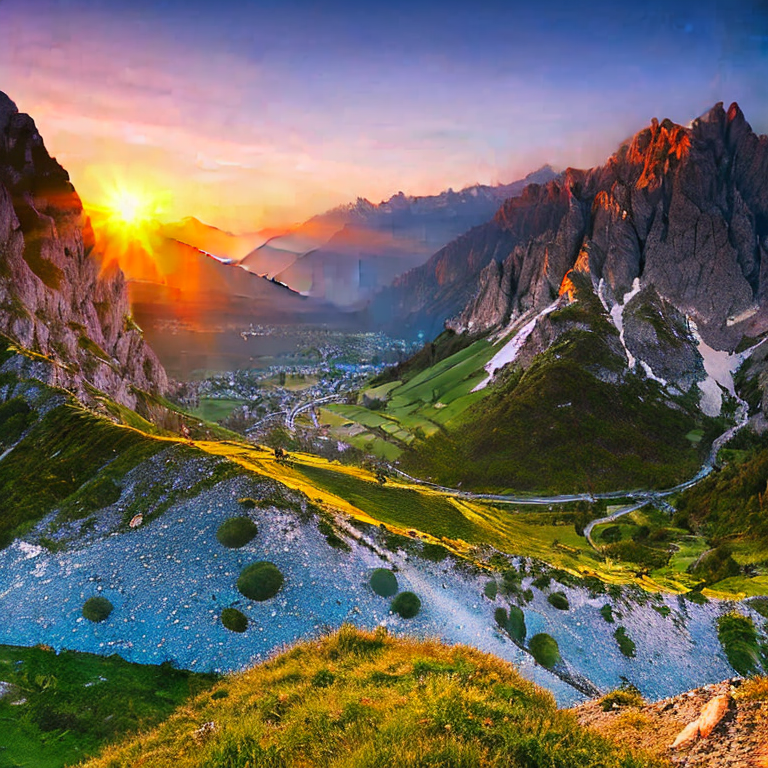

In [13]:
final_image = result['sample'][0]
final_image.save('result.png')
final_image

In [14]:
del ov_pipe
gc.collect()

4

## Stable Diffusion V2 Infinite Zoom Out

In this part of tutorial we consider how to use Stable Diffusion V2 model for generation sequence of images for infinite zoom video effect.
To do this, we will need [stabilityai/stable-diffusion-2-inpainting](https://huggingface.co/stabilityai/stable-diffusion-2-inpainting) model.

### Stable Diffusion Text guided Inpainting
In image editing, inpainting is a process of restoring missing parts of pictures. Most commonly applied to reconstructing old deteriorated images, removing cracks, scratches, dust spots, or red-eyes from photographs.

But with the power of AI and the Stable Diffusion model, inpainting can be used to achieve more than that. For example, instead of just restoring missing parts of an image, it can be used to render something entirely new in any part of an existing picture. Only your imagination limits it.

The workflow diagram explains how Stable Diffusion inpaining pipeline for inpainting works:

![sd2-inpainiting](https://user-images.githubusercontent.com/29454499/228501084-60f86a71-0907-4094-a796-96350264d8b8.png)

The pipeline has a lot of common with Text to Image generation pipeline discussed in previous section. Additionally to text prompt, pipeline accepts input source image and mask which provides an area of image which should be modified. Masked image encoded by VAE encoder into latent diffusion space and concatenated with randomly generated (on initial step only) or produced by Unet latent generated image representation and used as input for next step denoising.

Using this inpainting feature, decreasing image by certain margin and masking this border for every new frame we can create interesting Zoom Out video based on our prompt.

### Initialize PyTorch models

Diffusers library provides `StableDiffusionInpiantPipeline` for working with this model. The code below demonstrates how download and initialize this pipeline.

In [17]:
from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler

model_id = "stabilityai/stable-diffusion-2-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id)
scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

In [18]:
text_encoder = pipe.text_encoder
text_encoder.eval()
unet = pipe.unet
unet.eval()
vae = pipe.vae
vae.eval();

### Convert models to OpenVINO Intermediate representation (IR) format

Conversion part of model stayed remain and we will reuse conversion functionality defined above for all pipeline components. Except UNet now has 9 channels, which now calculated like 4 for unet generated latents channels + 4 for latent representation of masked image + 1 channel resized mask.

In [19]:
sd2_inpainting_model_dir = Path("sd2_inpainting")
sd2_inpainting_model_dir.mkdir(exist_ok=True)

In [20]:
TEXT_ENCODER_ONNX_PATH = sd2_inpainting_model_dir / "text_encoder.onnx"
TEXT_ENCODER_OV_PATH = TEXT_ENCODER_ONNX_PATH.with_suffix('.xml')

if not TEXT_ENCODER_OV_PATH.exists():
    convert_encoder_onnx(text_encoder, TEXT_ENCODER_ONNX_PATH)
    !mo --input_model $TEXT_ENCODER_ONNX_PATH --compress_to_fp16 --output_dir $sd2_inpainting_model_dir
    print('Text Encoder successfully converted to IR')
else:
    print(f"Text encoder will be loaded from {TEXT_ENCODER_OV_PATH}")

del text_encoder
gc.collect()

Text encoder will be loaded from sd2_inpainting/text_encoder.xml


0

In [21]:
UNET_ONNX_PATH = sd2_inpainting_model_dir / 'unet/unet.onnx'
UNET_OV_PATH = UNET_ONNX_PATH.parents[1] / 'unet.xml'

In [22]:
if not UNET_OV_PATH.exists():
    convert_unet_onnx(unet, UNET_ONNX_PATH, num_channels=9, width=64, height=64)
    del unet
    gc.collect()
    !mo --input_model $UNET_ONNX_PATH --compress_to_fp16 --output_dir $sd2_inpainting_model_dir
    print('Unet successfully converted to IR')
else:
    del unet
    print(f"Unet will be loaded from {UNET_OV_PATH}")
gc.collect()

Unet will be loaded from sd2_inpainting/unet.xml


0

In [23]:
VAE_ENCODER_ONNX_PATH = sd2_inpainting_model_dir / 'vae_encoder.onnx'
VAE_ENCODER_OV_PATH = VAE_ENCODER_ONNX_PATH.with_suffix('.xml')

if not VAE_ENCODER_OV_PATH.exists():
    convert_vae_encoder_onnx(vae, VAE_ENCODER_ONNX_PATH, 512, 512)
    !mo --input_model $VAE_ENCODER_ONNX_PATH --compress_to_fp16 --output_dir $sd2_inpainting_model_dir
    print('VAE encoder successfully converted to IR')
else:
    print(f"VAE encoder will be loaded from {VAE_ENCODER_OV_PATH}")

VAE_DECODER_ONNX_PATH = sd2_inpainting_model_dir / 'vae_decoder.onnx'
VAE_DECODER_OV_PATH = VAE_DECODER_ONNX_PATH.with_suffix('.xml')
if not VAE_DECODER_OV_PATH.exists():
    convert_vae_decoder_onnx(vae, VAE_DECODER_ONNX_PATH, 64, 64)
    !mo --input_model $VAE_DECODER_ONNX_PATH --compress_to_fp16 --output_dir $sd2_inpainting_model_dir
    print('VAE decoder successfully converted to IR')
else:
    print(f"VAE decoder will be loaded from {VAE_DECODER_OV_PATH}")

del vae

VAE encoder will be loaded from sd2_inpainting/vae_encoder.xml
VAE decoder will be loaded from sd2_inpainting/vae_decoder.xml


### Prepare Inference pipeline

In [24]:
def prepare_mask_and_masked_image(image, mask):
    """
    Prepares a pair (image, mask) to be consumed by the Stable Diffusion pipeline. This means that those inputs will be
    converted to ``torch.Tensor`` with shapes ``batch x channels x height x width`` where ``channels`` is ``3`` for the
    ``image`` and ``1`` for the ``mask``.

    The ``image`` will be converted to ``torch.float32`` and normalized to be in ``[-1, 1]``. The ``mask`` will be
    binarized (``mask > 0.5``) and cast to ``torch.float32`` too.

    Args:
        image (Union[np.array, PIL.Image, torch.Tensor]): The image to inpaint.
            It can be a ``PIL.Image``, or a ``height x width x 3`` ``np.array`` or a ``channels x height x width``
            ``torch.Tensor`` or a ``batch x channels x height x width`` ``torch.Tensor``.
        mask (_type_): The mask to apply to the image, i.e. regions to inpaint.
            It can be a ``PIL.Image``, or a ``height x width`` ``np.array`` or a ``1 x height x width``
            ``torch.Tensor`` or a ``batch x 1 x height x width`` ``torch.Tensor``.


    Raises:
        ValueError: ``torch.Tensor`` images should be in the ``[-1, 1]`` range. ValueError: ``torch.Tensor`` mask
        should be in the ``[0, 1]`` range. ValueError: ``mask`` and ``image`` should have the same spatial dimensions.
        TypeError: ``mask`` is a ``torch.Tensor`` but ``image`` is not
            (ot the other way around).

    Returns:
        tuple[torch.Tensor]: The pair (mask, masked_image) as ``torch.Tensor`` with 4
            dimensions: ``batch x channels x height x width``.
    """
    if isinstance(image, torch.Tensor):
        if not isinstance(mask, torch.Tensor):
            raise TypeError(f"`image` is a torch.Tensor but `mask` (type: {type(mask)} is not")

        # Batch single image
        if image.ndim == 3:
            assert image.shape[0] == 3, "Image outside a batch should be of shape (3, H, W)"
            image = image.unsqueeze(0)

        # Batch and add channel dim for single mask
        if mask.ndim == 2:
            mask = mask.unsqueeze(0).unsqueeze(0)

        # Batch single mask or add channel dim
        if mask.ndim == 3:
            # Single batched mask, no channel dim or single mask not batched but channel dim
            if mask.shape[0] == 1:
                mask = mask.unsqueeze(0)

            # Batched masks no channel dim
            else:
                mask = mask.unsqueeze(1)

        assert image.ndim == 4 and mask.ndim == 4, "Image and Mask must have 4 dimensions"
        assert image.shape[-2:] == mask.shape[-2:], "Image and Mask must have the same spatial dimensions"
        assert image.shape[0] == mask.shape[0], "Image and Mask must have the same batch size"

        # Check image is in [-1, 1]
        if image.min() < -1 or image.max() > 1:
            raise ValueError("Image should be in [-1, 1] range")

        # Check mask is in [0, 1]
        if mask.min() < 0 or mask.max() > 1:
            raise ValueError("Mask should be in [0, 1] range")

        # Binarize mask
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1

        # Image as float32
        image = image.to(dtype=torch.float32)
    elif isinstance(mask, torch.Tensor):
        raise TypeError(f"`mask` is a torch.Tensor but `image` (type: {type(image)} is not")
    else:
        # preprocess image
        if isinstance(image, (PIL.Image.Image, np.ndarray)):
            image = [image]

        if isinstance(image, list) and isinstance(image[0], PIL.Image.Image):
            image = [np.array(i.convert("RGB"))[None, :] for i in image]
            image = np.concatenate(image, axis=0)
        elif isinstance(image, list) and isinstance(image[0], np.ndarray):
            image = np.concatenate([i[None, :] for i in image], axis=0)

        image = image.transpose(0, 3, 1, 2)
        image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0

        # preprocess mask
        if isinstance(mask, (PIL.Image.Image, np.ndarray)):
            mask = [mask]

        if isinstance(mask, list) and isinstance(mask[0], PIL.Image.Image):
            mask = np.concatenate([np.array(m.convert("L"))[None, None, :] for m in mask], axis=0)
            mask = mask.astype(np.float32) / 255.0
        elif isinstance(mask, list) and isinstance(mask[0], np.ndarray):
            mask = np.concatenate([m[None, None, :] for m in mask], axis=0)

        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
        mask = torch.from_numpy(mask)

    masked_image = image * (mask < 0.5)

    return mask, masked_image

In [25]:
class OVStableDiffusionInpaintingPipeline(OVStableDiffusionPipeline):
    def prepare_mask_latents(
        self, mask, masked_image, batch_size, height, width, do_classifier_free_guidance
    ):
        # resize the mask to latents shape as we concatenate the mask to the latents
        # we do that before converting to dtype to avoid breaking in case we're using cpu_offload
        # and half precision
        mask = torch.nn.functional.interpolate(
            mask, size=(height // 8, width // 8)
        )
        mask = mask

        masked_image = masked_image

        # encode the mask image into latents space so we can concatenate it to the latents
        moments = self.vae_encoder(masked_image)[self._vae_e_output]
        mean, logvar = np.split(moments, 2, axis=1) 
        std = np.exp(logvar * 0.5)
        masked_image_latents = torch.from_numpy((mean + std * np.random.randn(*mean.shape)) * 0.18215)
        #masked_image_latents *= 0.18215

        # duplicate mask and masked_image_latents for each generation per prompt, using mps friendly method
        if mask.shape[0] < batch_size:
            if not batch_size % mask.shape[0] == 0:
                raise ValueError(
                    "The passed mask and the required batch size don't match. Masks are supposed to be duplicated to"
                    f" a total batch size of {batch_size}, but {mask.shape[0]} masks were passed. Make sure the number"
                    " of masks that you pass is divisible by the total requested batch size."
                )
            mask = mask.repeat(batch_size // mask.shape[0], 1, 1, 1)
        if masked_image_latents.shape[0] < batch_size:
            if not batch_size % masked_image_latents.shape[0] == 0:
                raise ValueError(
                    "The passed images and the required batch size don't match. Images are supposed to be duplicated"
                    f" to a total batch size of {batch_size}, but {masked_image_latents.shape[0]} images were passed."
                    " Make sure the number of images that you pass is divisible by the total requested batch size."
                )
            masked_image_latents = masked_image_latents.repeat(batch_size // masked_image_latents.shape[0], 1, 1, 1)

        mask = torch.cat([mask] * 2) if do_classifier_free_guidance else mask
        masked_image_latents = (
            torch.cat([masked_image_latents] * 2) if do_classifier_free_guidance else masked_image_latents
        )
        return mask, masked_image_latents

    def __call__(self, prompt: Union[str, List[str]], image: PIL.Image.Image, mask_image: PIL.Image.Image, negative_prompt: Union[str, List[str]] = None, num_inference_steps: Optional[int] = 50, guidance_scale: Optional[float] = 7.5, eta: Optional[float] = 0, output_type: Optional[str] = "pil", seed: Optional[int] = None):
            
        if seed is not None:
            np.random.seed(seed)
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get prompt text embeddings
        text_embeddings = self._encode_prompt(prompt, do_classifier_free_guidance=do_classifier_free_guidance, negative_prompt=negative_prompt)
        #prepare mask
        mask, masked_image = prepare_mask_and_masked_image(image, mask_image)
        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        if accepts_offset:
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)
        timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, 1)
        latent_timestep = timesteps[:1]

        # get the initial random noise unless the user supplied it
        latents, meta = self.prepare_latents(None, latent_timestep)
        mask, masked_image_latents = self.prepare_mask_latents(
            mask,
            masked_image,
            1,
            512,
            512,
            do_classifier_free_guidance,
        )

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        for t in self.progress_bar(timesteps):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = np.concatenate([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
            latent_model_input = np.concatenate([latent_model_input, mask, masked_image_latents], axis=1)
            # predict the noise residual
            noise_pred = self.unet([latent_model_input, float(t), text_embeddings])[self._unet_output]
            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(torch.from_numpy(noise_pred), t, torch.from_numpy(latents), **extra_step_kwargs)["prev_sample"].numpy()
        # scale and decode the image latents with vae
        image = self.vae_decoder(latents)[self._vae_d_output]

        image = self.postprocess_image(image, meta, output_type)
        return {"sample": image} 

In [40]:
def shrink_and_paste_on_blank(current_image, mask_width):
  """
  Decreases size of current_image by mask_width pixels from each side,
  then adds a mask_width width transparent frame, 
  so that the image the function returns is the same size as the input. 
  :param current_image: input image to transform
  :param mask_width: width in pixels to shrink from each side
  """

  height = current_image.height
  width = current_image.width

  #shrink down by mask_width
  prev_image = current_image.resize((height-2*mask_width,width-2*mask_width))
  prev_image = prev_image.convert("RGBA")
  prev_image = np.array(prev_image)

  #create blank non-transparent image
  blank_image = np.array(current_image.convert("RGBA"))*0
  blank_image[:,:,3] = 1

  #paste shrinked onto blank
  blank_image[mask_width:height-mask_width,mask_width:width-mask_width,:] = prev_image
  prev_image = PIL.Image.fromarray(blank_image)

  return prev_image


def image_grid(imgs, rows, cols):
  assert len(imgs) == rows*cols

  w, h = imgs[0].size
  grid = PIL.Image.new('RGB', size=(cols*w, rows*h))

  for i, img in enumerate(imgs):
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

def write_video(file_path, frames, fps, reversed = True):
  """
  Writes frames to an mp4 video file
  :param file_path: Path to output video, must end with .mp4
  :param frames: List of PIL.Image objects
  :param fps: Desired frame rate
  :param reversed: if order of images to be reversed (default = True)
  """
  if reversed:
    frames.reverse()

  w, h = frames[0].size
  fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
  #fourcc = cv2.VideoWriter_fourcc(*'avc1')
  writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))

  for frame in frames:
      np_frame = np.array(frame.convert('RGB'))
      cv_frame = cv2.cvtColor(np_frame, cv2.COLOR_RGB2BGR)
      writer.write(cv_frame)

  writer.release()

### Zoom In Video Generation

In [45]:
def generate_video(
        pipe,
        prompt,
        negative_prompt,
        guidance_scale,
        num_inference_steps,
        ):
        

        num_init_images = 1
        seed = 9999 
        height = 512
        width = height 

        current_image = PIL.Image.new(mode="RGBA", size=(height, width))
        mask_image = np.array(current_image)[:,:,3] 
        mask_image = PIL.Image.fromarray(255-mask_image).convert("RGB")
        current_image = current_image.convert("RGB")

        init_images =  pipe(prompt=prompt*num_init_images,
                            negative_prompt=negative_prompt*num_init_images,
                            image=current_image,
                            guidance_scale = guidance_scale,
                            mask_image=mask_image,
                            seed=seed,
                            num_inference_steps=num_inference_steps)["sample"]


        image_grid(init_images, rows=1, cols=num_init_images)


        init_image_selected = 1 #@param
        if num_init_images == 1:
            init_image_selected = 0
        else:
            init_image_selected = init_image_selected - 1

        num_outpainting_steps = 20 #@param
        mask_width = 128 #@param
        num_interpol_frames = 30 #@param 

        current_image = init_images[init_image_selected]
        all_frames = []
        all_frames.append(current_image)

        for i in range(num_outpainting_steps):
            print('Generating image: ' + str(i+1) + ' / ' + str(num_outpainting_steps))

            prev_image_fix = current_image

            prev_image = shrink_and_paste_on_blank(current_image, mask_width)

            current_image = prev_image

            #create mask (black image with white mask_width width edges)
            mask_image = np.array(current_image)[:,:,3] 
            mask_image = PIL.Image.fromarray(255-mask_image).convert("RGB")

            #inpainting step
            current_image = current_image.convert("RGB")
            images = pipe(prompt=prompt,
                            negative_prompt=negative_prompt,
                            image=current_image,
                            guidance_scale = guidance_scale,
                            #this can make the whole thing deterministic but the output less exciting
                            #generator = g_cuda.manual_seed(seed), 
                            mask_image=mask_image,
                            seed=seed,
                            num_inference_steps=num_inference_steps)["sample"]
            current_image = images[0]
            current_image.paste(prev_image, mask=prev_image)

            #interpolation steps bewteen 2 inpainted images (=sequential zoom and crop)
            for j in range(num_interpol_frames - 1):
                interpol_image = current_image
                interpol_width = round(
                    (1- ( 1-2*mask_width/height )**( 1-(j+1)/num_interpol_frames ) )*height/2 
                    )
                interpol_image = interpol_image.crop((interpol_width,
                                                    interpol_width,
                                                    width - interpol_width,
                                                    height - interpol_width))

                interpol_image = interpol_image.resize((height, width))

                #paste the higher resolution previous image in the middle to avoid drop in quality caused by zooming
                interpol_width2 = round(
                    ( 1 - (height-2*mask_width) / (height-2*interpol_width) ) / 2*height
                    )
                prev_image_fix_crop = shrink_and_paste_on_blank(prev_image_fix, interpol_width2)
                interpol_image.paste(prev_image_fix_crop, mask = prev_image_fix_crop)

                all_frames.append(interpol_image)

            all_frames.append(current_image)

        video_file_name = "infinite_zoom_out"
        fps = 30 
        save_path = video_file_name + ".mp4"
        write_video(save_path, all_frames, fps)
        return save_path

### Configure Inference Pipeline

Configuration steps are the same like for Text to Image:
1. Load models on device
2. Configure tokenizer and scheduler
3. Create instance of OvStableDiffusionInpaintingPipeline class.

In [42]:
text_enc = core.compile_model(TEXT_ENCODER_OV_PATH, "CPU")
unet_model = core.compile_model(UNET_OV_PATH, 'CPU')
vae_decoder = core.compile_model(VAE_DECODER_OV_PATH, 'CPU')
vae_encoder = core.compile_model(VAE_ENCODER_OV_PATH, 'CPU')

pipe = OVStableDiffusionInpaintingPipeline(tokenizer=tokenizer,
    text_encoder=text_enc,
    unet=unet_model,
    vae_encoder=vae_encoder,
    vae_decoder=vae_decoder,
    scheduler=scheduler)

### Run Infinite Zoom In video generation

In [43]:
original_prompt = [
    "A Hyperrealistic photograph of ancient Paris architectural ruins in a flooded apocalypse landscape, lens flares, cinematic, hdri, matte painting, concept art, celestial, soft render, highly detailed, cgsociety, octane render, trending on artstation, architectural HD, HQ, 4k, 8k "]

negative_prompt = ["lurry, bad art, blurred, text, watermark"]

In [46]:
output_file = generate_video(pipe, original_prompt, negative_prompt, 7.5, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 1 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 2 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 3 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 4 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 5 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 6 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 7 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 8 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 9 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 10 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 11 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 12 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 13 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 14 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 15 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 16 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 17 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 18 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 19 / 20


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image: 20 / 20


  0%|          | 0/20 [00:00<?, ?it/s]